In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [327]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [328]:
import sys
sys.path.append('..')
from dataset import batcher

In [329]:
MODEL_DIR = '../saved_models/'
LR_RATE = 0.001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [330]:
# Load model
experiments = ['imagery_sample_cnn_regression_vgg2']

def load_model_from_dir(model_name):
    model_path = MODEL_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [331]:
# Get test split
test_batcher = batcher.Batcher(bucket=False, shuffle=False, split='test', repeat=1, batch_size=652).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

(1, 652, 224, 224, 3)


In [332]:
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
            loss=LOSS,
            optimizer=OPT,
            metrics=METRICS,
        )

y_preds = trained_model.predict_on_batch(x_true)
print(y_preds)

2023-02-04 10:11:50.237215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[[241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]
 [241.12115]

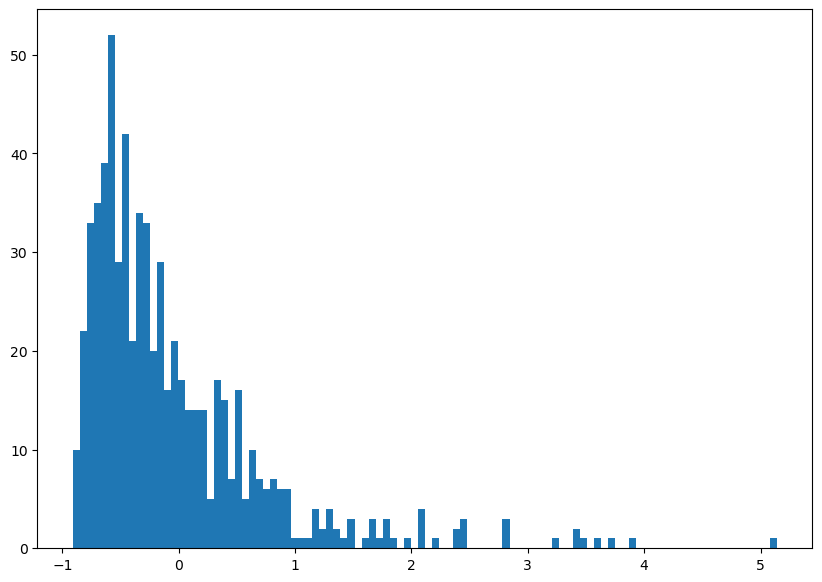

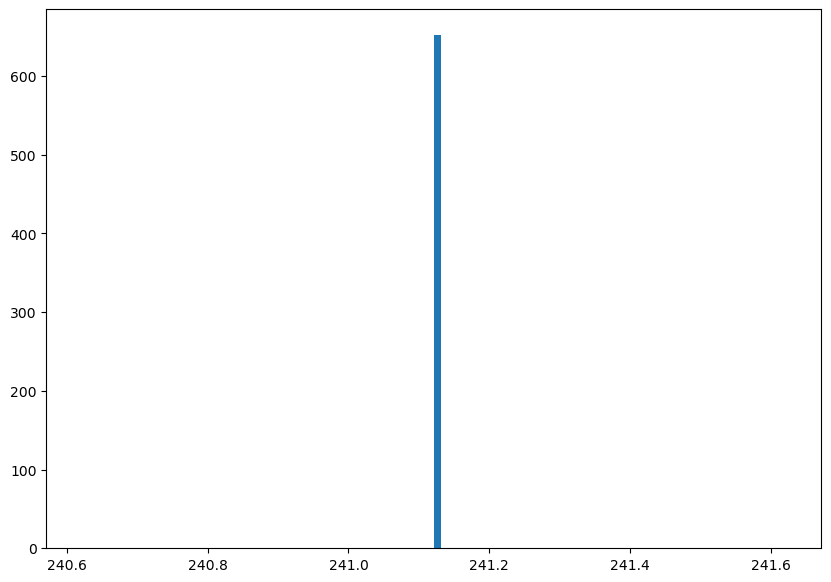

/Users/omshah/opt/anaconda3/envs/pypoverty38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [333]:
# Find r-squared
y_true = np.squeeze(y_true)
y_preds = np.squeeze(y_preds)

# Plot histograms
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_true, bins = 100)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_preds, bins = 100)
plt.show()


r2 = pearsonr(y_true, y_preds)[0]

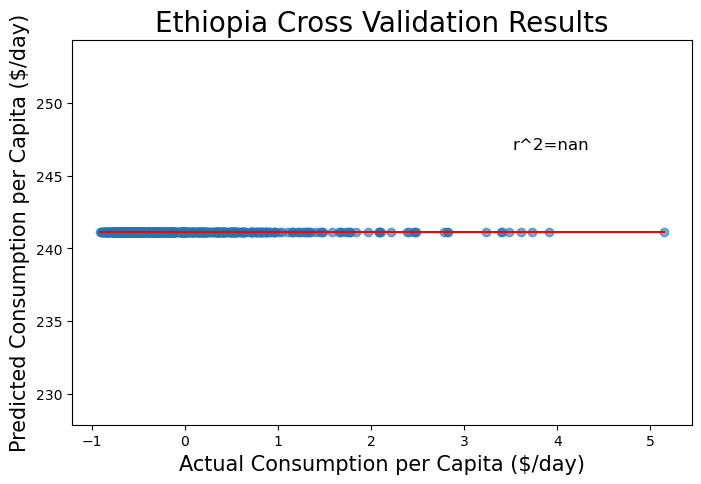

In [334]:
# Plot predictions
country = 'Ethiopia'
fig = plt.figure(figsize=(8,5))
plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_preds, 1))(np.unique(y_true)), color='red')
plt.text(0.5, 0.5, f'r^2={round(r2, 2)}', ha='left', va='top', size=12, transform=ax.transAxes)
plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
plt.title(f'{country} Cross Validation Results', fontsize=20)
# plt.xlim([np.min(y_true), 10])
# plt.ylim([np.min(y_true), 10])
plt.show()